In [3]:
# чтение спектров и подготовка 

import os

directory = 'H:/Data/1_ДИПЛОМНАЯ РАБОТА/Интегрирование/Collimator_100_0_line' #
list_of_files = os.listdir(directory) #список файлов
bulls= []
for i in list_of_files:
    with open(directory + '/'+ i, 'r') as f:
        tmp=f.readlines()
        bulls.append(tmp)

chanel=[] # список массивов каналов
for j in bulls:
    a = j[0].split(' ') # чтение живого времени
    t = a[3] 
    t=t.replace(',', '.')
    time=float(t[:len(t)-2])
    #print('Живое время = ',time, ' секунд')
    ch = []           # список каналов
    for i in range(2,4098):  # чтение импульсов в каналах
        a = j[i].split(' ')
        ch.append(a[2])
    ch=list(map(float, ch))    
    ch=list(map(lambda x: x/time,ch))
    chanel.append(ch)
# сейчас у меня есть список из 12 элементов, каждый из которых это массив импульсов по каналам.   
# а последний элемент, это массив импульсов для фона 

import matplotlib.pyplot as plt
%matplotlib inline



[0.022862878492165284, 0.024535772040372498, 0.026208665588579715, 0.02342050967490102, 0.022305247309429545, 0.026208665588579715, 0.029833268276362016, 0.033457870964144314, 0.02843919031952267, 0.02843919031952267, 0.030112083867729886, 0.0317849774159371, 0.028996821502258407, 0.02788155913678693, 0.028996821502258407, 0.030112083867729886, 0.02676629677131545, 0.03066971505046562, 0.03150616182456923, 0.032342608598672835, 0.025093403223108237, 0.033457870964144314, 0.025372218814476107, 0.017286566664807896, 0.021189984943958066, 0.028996821502258407, 0.025093403223108237, 0.021189984943958066, 0.030112083867729886, 0.019517091395750853, 0.03959181397423744, 0.033457870964144314, 0.02732392795405119, 0.03513076451235153, 0.025651034405843976, 0.028996821502258407, 0.032342608598672835, 0.039034182791501705, 0.03568839569508727, 0.04377404784475548, 0.05185969999442369, 0.06133943010093124, 0.06468521719734567, 0.07500139407795683, 0.08531757095856801, 0.09312440751686835, 0.11487

In [6]:
# метод скользящего среднего

i=0
j=0
p=0
for i in range(11):
    for j in range(200):
        p=j+450
        chanel[i][p]=1/5*(sum([chanel[i][p-2],chanel[i][p-1],chanel[i][p],chanel[i][p+1],chanel[i][p+2]]))

        

In [7]:
# поиск констант и подсчет интеграла

from scipy.optimize import minimize
from scipy import integrate
import numpy as np

h=1 #высота от детектора до источника
chanel_out=[]
x=np.arange(0,1.1,0.1) 

f_out=open('koeff.txt', 'w')
f_tmpout_alpha=open('tmp_alpha.txt', 'w')
f_tmpout_beta=open('tmp_beta.txt', 'w')
f_tmplast_alpha=open('tmplast_alpha.txt', 'w')
f_tmplast_beta=open('tmplast_beta.txt', 'w')

ch_alpha=[]
ch_beta=[]

for p in range(4096):
    
    def f(x,alpha,beta):
         return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)
    def delta(alpha, beta):
        d=0
        for i in range(10):
            d=d+(f(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res=minimize(lambda x: delta(*x), [1,1])
    a=res.x[0]
    b=res.x[1]
    f_out.write(str(p) + '   alpha=' + str("%.4f" % a) + ' beta=' + str("%.4f" % b) + ',    ')
    f_tmpout_alpha.write(str("%.6f" % a) + '\n')
    f_tmpout_beta.write(str("%.6f" % b) + '\n')
    #     if p==133:
    #    print(a,b)

    # получил альфа и бета для интерполирующей функции на всем интервале

    def g(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)
    
    carpet=integrate.quad(g,0,1)

    # проинтегрировал интерполирующую функцию на интервале (0,1)

    def f_last(x, alpha,beta):
        return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)

    def delta_last(alpha,beta):
        d=0
        for i in range(9,10):
            d=d+(f(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res_last=minimize(lambda x: delta_last(*x), [1,1])
    a=res_last.x[0]
    b=res_last.x[1]
    f_out.write('на последнем интервале alpha='+ str("%.4f" % a) + ', beta= ' + str("%.4f" % b) + '\n')
    ch_alpha.append(a)
    ch_beta.append(b)
    f_tmplast_alpha.write(str("%.6f" % a) + '\n')
    f_tmplast_beta.write(str("%.6f" % b) + '\n')
    #     if p==133:
    #         print(a,b)

    # получил альфа и бета для последнего интервала

    def g_last(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)
    #carpet_last=integrate.quad(g_last,1, np.inf)
    carpet_last=integrate.quad(g_last,1, np.inf)
    # проинтегрировал интерполирующую функцию с коэффициентами из последнего интервала по бесконечности
    chanel_out.append(carpet[0]+carpet_last[0])
    #print(carpet[0], carpet_last[0])

f_integr=open('integr.txt', 'w')
f_integr.write('кэВ  ' + '  имп*м*м/с' + '\n')
for i in range(4095):
    f_integr.write(str(i) + '  ' + str("%.4f" % chanel_out[i]) + '\n')

f_out.close()
f_tmplast_alpha.close()    
f_tmplast_beta.close()
f_integr.close()
f_tmpout_alpha.close()
f_tmpout_beta.close()

C:\Users\Python_amateur\anaconda3\lib\site-packages\ipykernel_launcher.py:70: IntegrationWarning: The integral is probably divergent, or slowly convergent.


In [175]:
def g_last(x):
    a,b = 1.4147434979760465, 0.86660678985018
    return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)


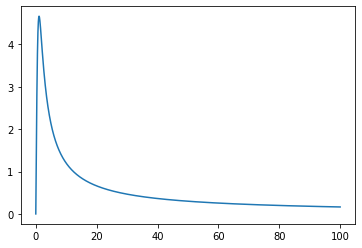

In [176]:
plt.plot(np.arange(0,100,0.01),g_last(np.arange(0,100,0.01)))

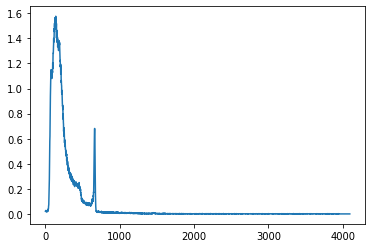

In [188]:
ch_tmp=[]
for j in range(4095):
    ch_tmp.append(chanel[4][j])

plt.plot(np.arange(1,4096,1), ch_tmp)

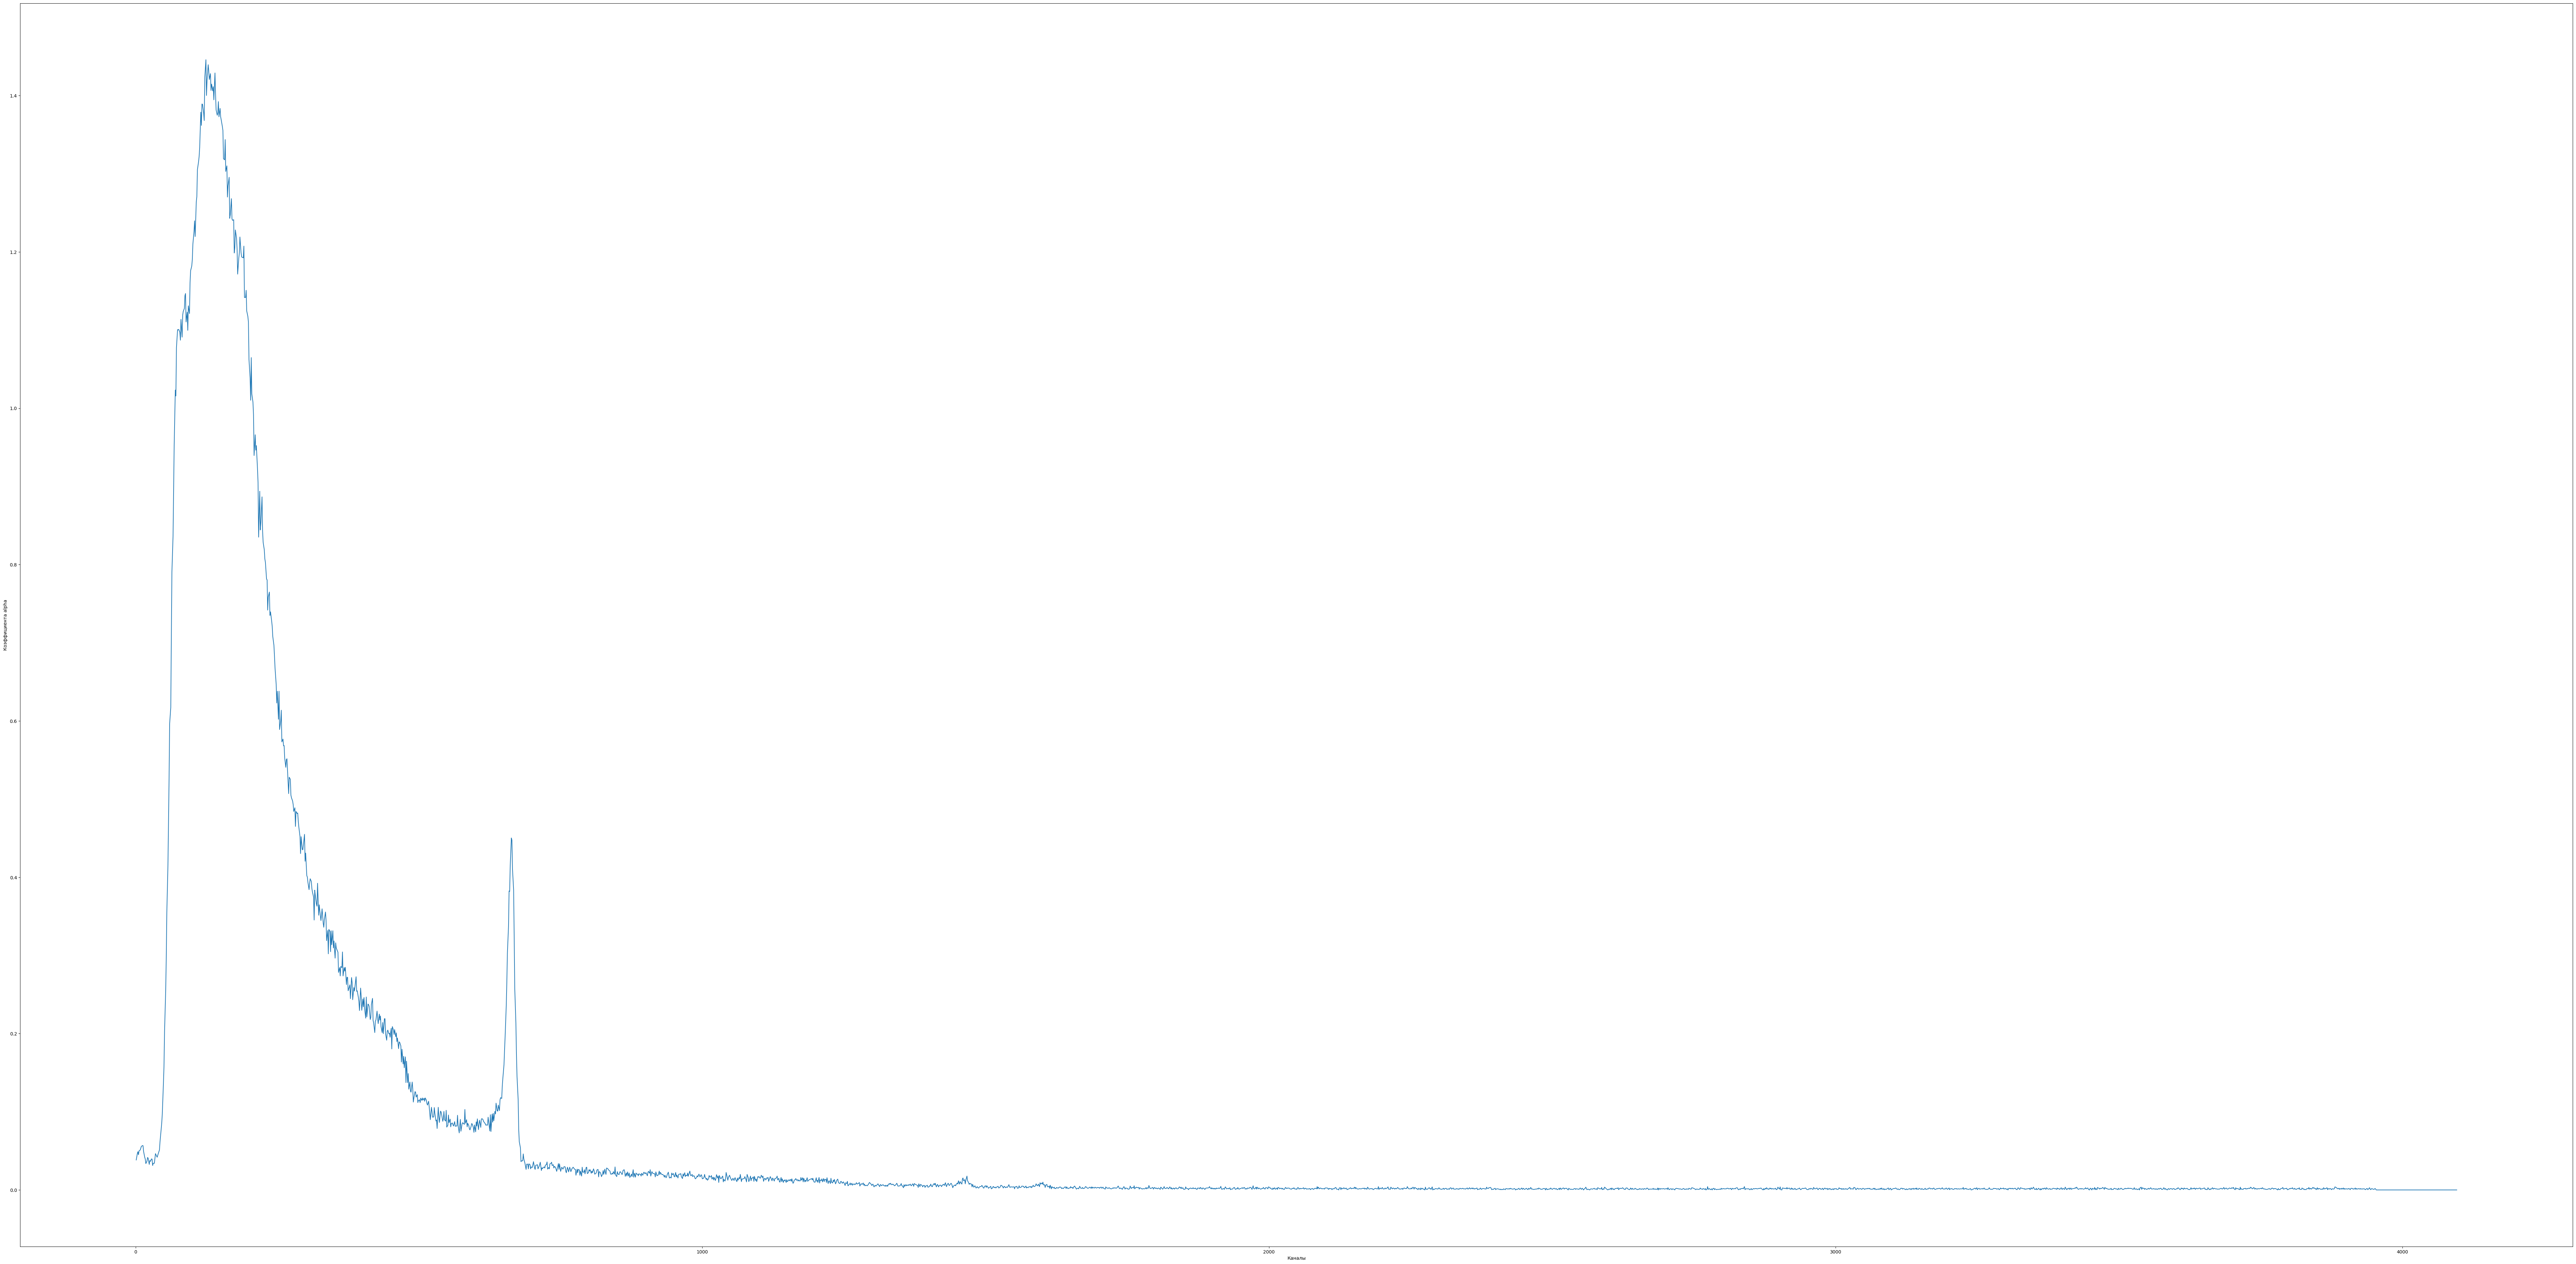

In [210]:

fig=plt.figure(figsize=(100,50), dpi=100)
plt.plot(np.arange(1,4097,1), ch_alpha)
plt.xlabel('Каналы')
plt.ylabel('Коэффициента alpha')
fig.savefig('alpha', fmt='png')

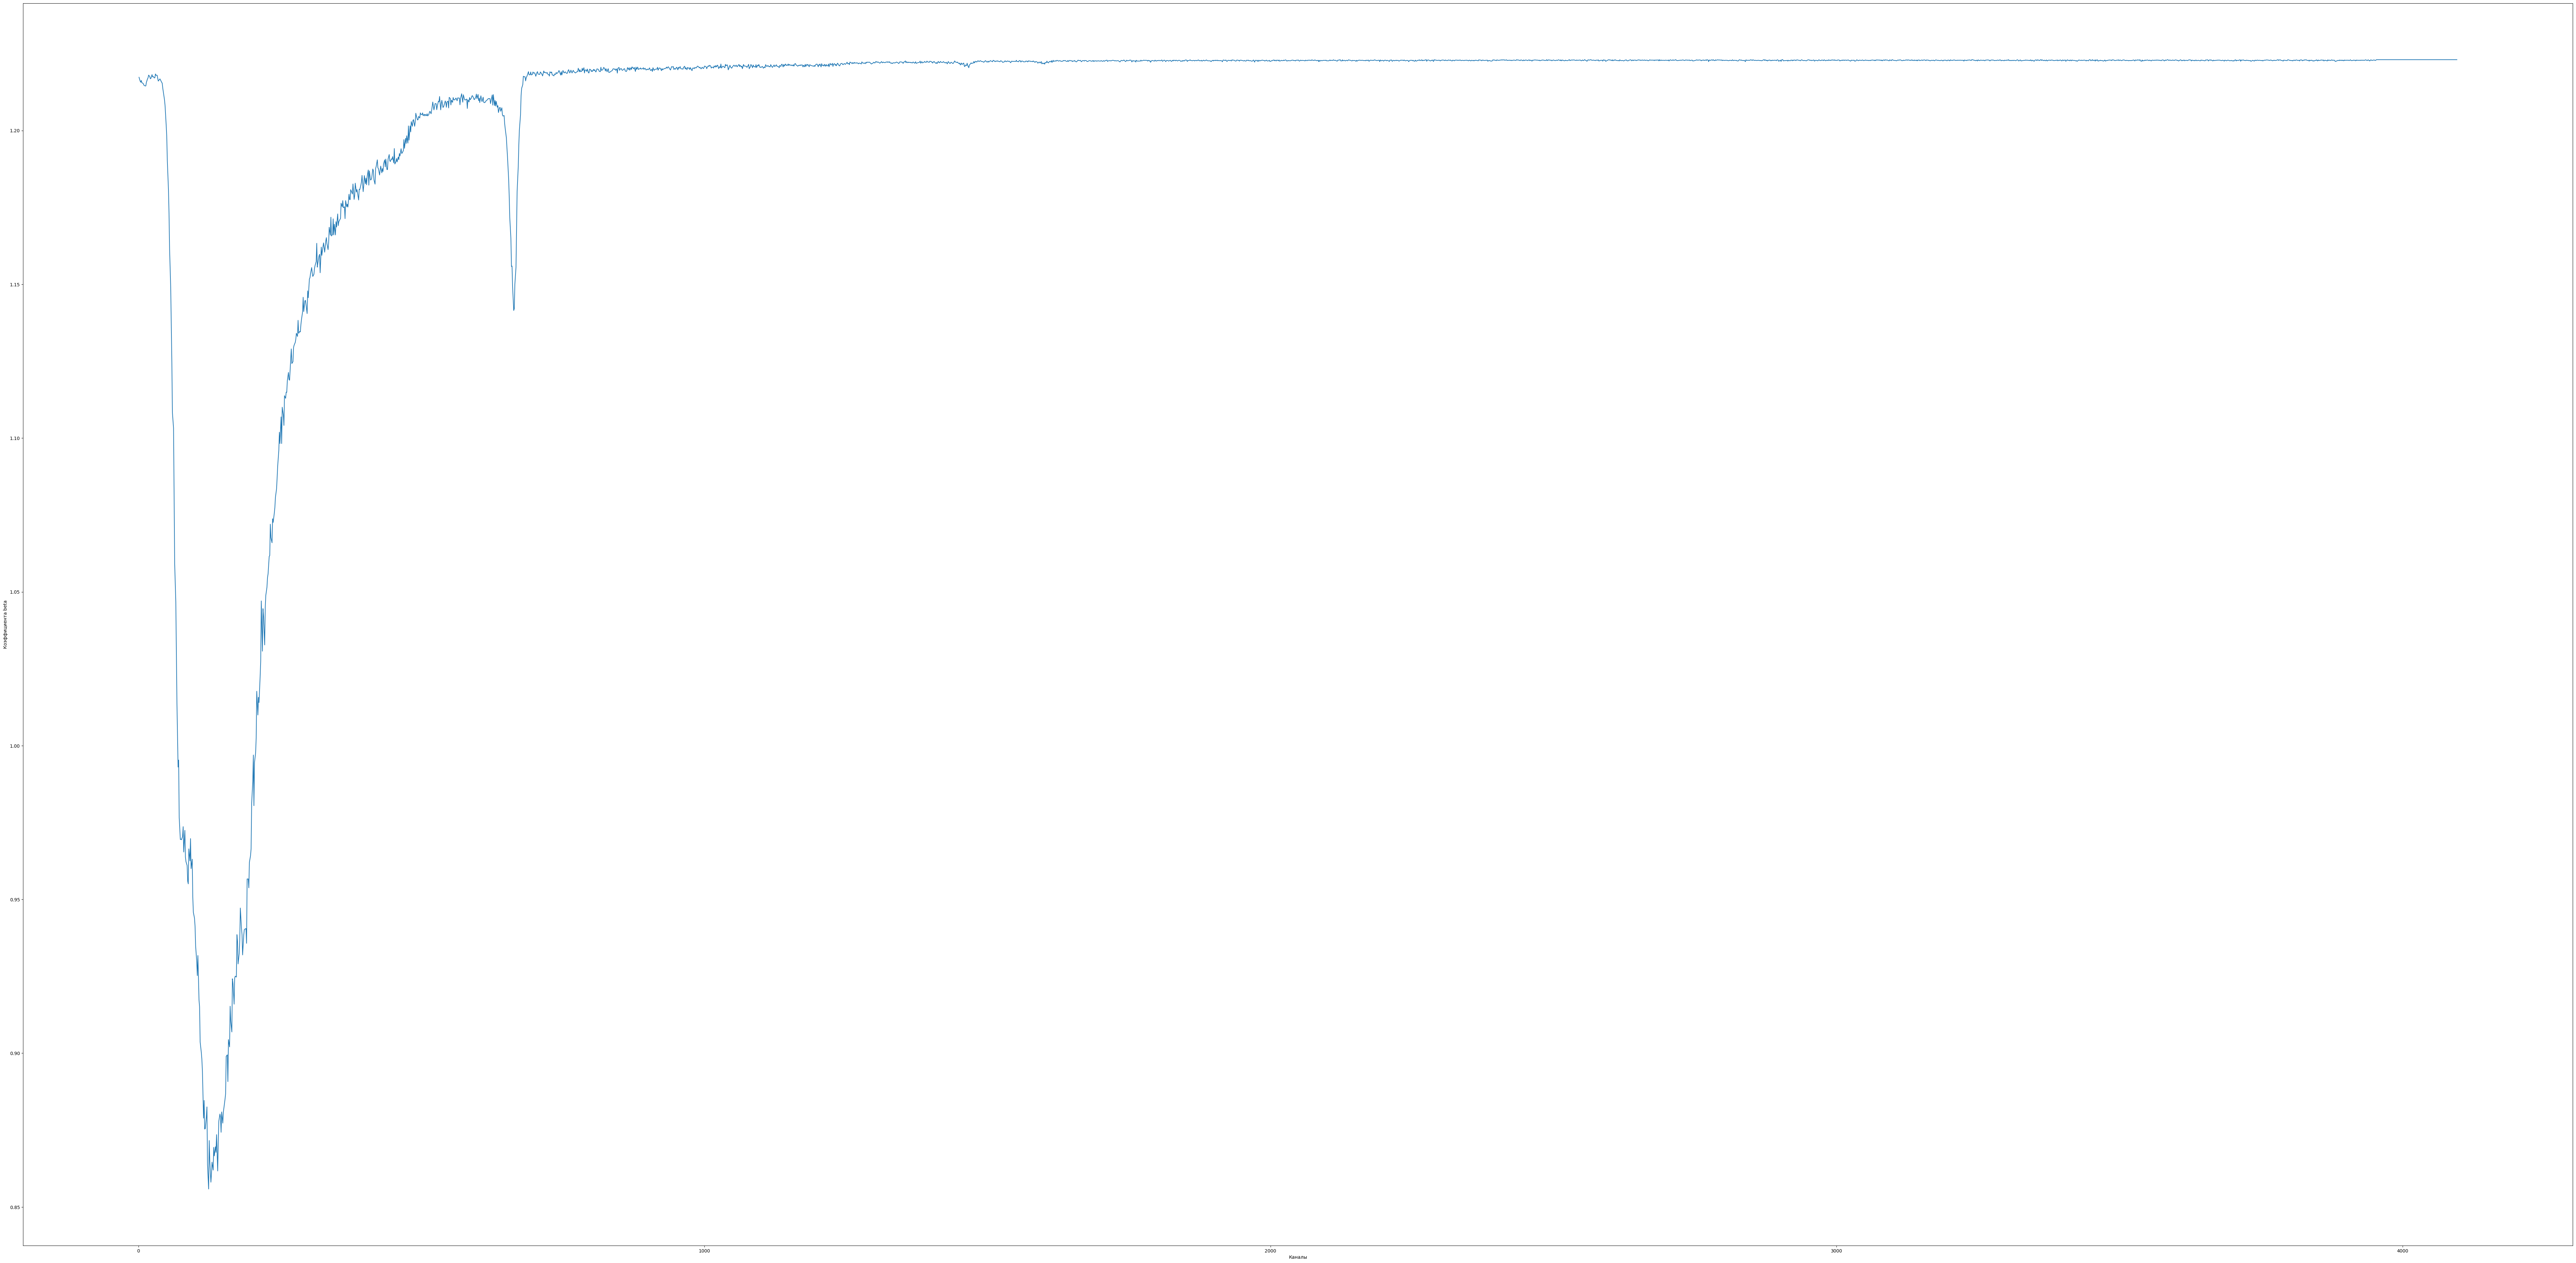

In [211]:
fig_1=plt.figure(figsize=(100,50), dpi=100)
plt.plot(np.arange(1,4097,1), ch_beta)
plt.xlabel('Каналы')
plt.ylabel('Коэффициента beta')
fig_1.savefig('beta', fmt='png')